In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from prophet import Prophet

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
data = pd.read_csv('../data/regional_multivariate_data.csv')


enc = pd.read_csv('../data/regional_datasets/multivariate/enc_data_multi.csv').drop(columns = 'Unnamed: 0')
esc = pd.read_csv('../data/regional_datasets/multivariate/esc_data_multi.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/multivariate/mid_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/multivariate/mountain_data_multi.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/multivariate/new_england_data_multi.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/multivariate/pacific_data_multi.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/multivariate/south_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/multivariate/wnc_data_multi.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/multivariate/wsc_data_multi.csv').drop(columns = 'Unnamed: 0')

# def log_transform(x):
#     return np.log(x) if x > 0 else 0

def prepare_and_split_data(data, test_size = 0.15):
    data = data.copy() 
    data = data.rename(columns = {'date': 'ds', 'new_confirmed':'y'})
    data = data.sort_values(by = 'ds')

    # This removes the first n observations so that there are no NaNs in the lag columns
    last_nan = data[data.isna().any(axis = 1)].tail(1).index.item()
    data = data[(last_nan + 1):]
    # data['y'] = data['y'].apply(lambda x: log_transform(x))
    testsize = int(len(data) * (1-test_size))
    train, test = data[0:testsize], data[testsize:]
    return train, test

enc_train, enc_test = prepare_and_split_data(enc)
esc_train, esc_test = prepare_and_split_data(esc)
midatl_train, midatl_test = prepare_and_split_data(midatl)
mount_train, mount_test = prepare_and_split_data(mount)
ne_train, ne_test = prepare_and_split_data(ne)
pac_train, pac_test = prepare_and_split_data(pac)
satl_train, satl_test = prepare_and_split_data(satl)
wnc_train, wnc_test = prepare_and_split_data(wnc)
wsc_train, wsc_test = prepare_and_split_data(wsc)
print("Length enc train: ", len(enc_train))
print("Length enc test: ", len(midatl_test))

midatl_test.head()

Length enc train:  727
Length enc test:  126


,region,ds,y,new_deceased,cumulative_confirmed,cumulative_deceased,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,...,facial_coverings,vaccination_policy,stringency_index,minimum_temperature_celsius,maximum_temperature_celsius,1_day_shift,7_day_avg,2_day_shift,8_day_shift,9_day_shift
720,Mid-Atlantic,2022-02-21,4514.0,79.0,9797202.0,141918.0,435.0,537379.0,5374.0,925.0,...,2.0,5.0,39.196667,-6.623457,15.271605,4437.0,7340.000000,7660.0,8909.0,9569.0
721,Mid-Atlantic,2022-02-22,5425.0,99.0,9802627.0,142017.0,540.0,537919.0,5192.0,851.0,...,2.0,5.0,39.196667,-3.395062,16.981481,4514.0,7208.857143,4437.0,5665.0,8909.0
722,Mid-Atlantic,2022-02-23,6388.0,332.0,9809015.0,142349.0,504.0,538423.0,4944.0,818.0,...,2.0,5.0,39.196667,-4.355556,21.122222,5425.0,6954.142857,4514.0,6343.0,5665.0
723,Mid-Atlantic,2022-02-24,6277.0,151.0,9815292.0,142500.0,512.0,538935.0,4706.0,796.0,...,2.0,5.0,39.196667,-10.905556,12.709877,6388.0,6396.857143,5425.0,8171.0,6343.0
724,Mid-Atlantic,2022-02-25,5569.0,163.0,9820861.0,142663.0,516.0,539451.0,4529.0,772.0,...,2.0,5.0,39.196667,-10.488889,7.877778,6277.0,5752.857143,6388.0,10178.0,8171.0


In [4]:
def search_prophet(train, test, changepoints = np.logspace(-3, -1, num = 5), seasonalities = np.array([10, 100, 500]), n_changepoints_vals = np.array([15, 25, 50]), transformation = None, figsize = (10,6), holidays = 'True'):
    models = {}

    for changepoint, seasonality, n_changepoint in itertools.product(changepoints, seasonalities, n_changepoints_vals):
        model = Prophet(changepoint_prior_scale=changepoint)
        for col in train.columns:
            if col not in ['ds', 'y', 'region']:
                model.add_regressor(col)
        if holidays == 'True':
            model.add_country_holidays(country_name= 'US')
        model.fit(train)

        test_forecast = model.predict(test)

        test['ds'] = pd.to_datetime(test['ds'])
        test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

        min_test_date = test['ds'].min()
        max_test_date = test['ds'].max()
        forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
        
        y_actual = test['y'].values
        y_pred = forecast_filtered['yhat'].values

        # mae = mean_absolute_error(y_actual, y_pred) 
        # rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
        mase = mean_absolute_scaled_error(y_actual, y_pred, y_train = train['y'])
        
        models[changepoint] = (model, mase, test_forecast, changepoint, seasonality, n_changepoint)

    best_changepoint = min(models, key = lambda k: models[k][1])
    model, best_mase, test_forecast, changepoint, seasonality, n_changepoint = models[best_changepoint] 
    print('changepoint_prior_scale: ', changepoint)
    print('seasonality_prior_scale: ', seasonality)
    print('n_changepoints: ', n_changepoint)

    train_forecast = model.predict(train)

    combined_forecast = pd.concat([train_forecast, test_forecast], ignore_index=True)

    fig1 = model.plot(combined_forecast)
    fig2 = model.plot_components(combined_forecast)

    test['ds'] = pd.to_datetime(test['ds'])
    test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

    min_test_date = test['ds'].min()
    max_test_date = test['ds'].max()
    forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
    for i in range(len(forecast_filtered['yhat'])):
        if forecast_filtered['yhat'][i] < 0:
            forecast_filtered['yhat'][i] = 0


    plt.figure(figsize = figsize)
    plt.plot(test['ds'], test['y'], label='New Cases', color='blue')
    plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Predicted New Cases', color='red')
    # plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Caseload')
    plt.title('Actual and Predicted Daily New Cases')
    plt.legend()
    plt.show()

    y_actual = test['y'].values
    y_pred = forecast_filtered['yhat'].values
    for i in range(len(y_pred)):
        if y_pred[i] < 0:
            y_pred[i] = 0

    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mse = mean_squared_error(y_actual, y_pred)
    mase = mean_absolute_scaled_error(y_actual, y_pred, y_train = train['y'])

    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MSE: {mse}")
    print(f"MASE: {mase}")

    test_avg = test.copy()
    test_avg['7_day_avg'] = test_avg['y'].rolling(window=7).mean()
    forecast_filtered['7_day_avg'] = forecast_filtered['yhat'].rolling(window=7).mean()

    plt.figure(figsize = figsize)
    plt.plot(test_avg['ds'], test_avg['7_day_avg'], label='7-Day Avg New Cases', color='blue', linestyle='--')
    plt.plot(forecast_filtered['ds'], forecast_filtered['7_day_avg'], label='7-Day Avg Predicted New Cases', color='red', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Caseload')
    plt.title('Actual and Predicted Daily New Cases')
    plt.legend()
    plt.show()

    y_actual = test_avg['7_day_avg'].values
    y_actual = y_actual[7:]
    y_pred = forecast_filtered['7_day_avg'].values
    y_pred = y_pred[7:]

    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mse = mean_squared_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)

    # Calculate MASE
    naive = y_actual[:-1]
    naive_mae = mean_absolute_error(y_actual[1:], naive)
    mase = mae / naive_mae

    print(f"7-Day Avg MAE: {mae}")
    print(f"7-Day Avg RMSE: {rmse}")
    print(f"7-Day Avg MSE: {mse}")
    print(f"7-Day Avg MASE: {mase}")
    print(f"7-Day Avg MAPE: {mape}")

    return model, models, forecast_filtered, fig1, fig2

In [5]:
def check_hyperparams(train, test, changepoints = np.logspace(-3.5, .5, num = 50), seasonalities = np.logspace(-2, 4, num = 50), \
                      n_changepoints_vals = np.logspace(1, 3, num = 50), param = 'changepoint_prior_scale', metric = 'MASE'):
    param_vals = []
    mae_values = []
    rmse_values = []
    mase_values = []

    if param == 'changepoint_prior_scale':
        for cps in changepoints:
            m = Prophet(changepoint_prior_scale=cps)
            for col in train.columns:
                if col not in ['ds', 'y', 'region']:
                    m.add_regressor(col)
            m.fit(train)
            
            forecast = m.predict(test)

            forecasted = forecast['yhat'][-len(test):]
            mae = mean_absolute_error(test['y'], forecasted)
            rmse = np.sqrt(mean_squared_error(test['y'], forecasted))
            mase = mean_absolute_scaled_error(test['y'], forecasted, y_train = train['y'])
            
            param_vals.append(cps)
            mae_values.append(mae)
            rmse_values.append(rmse)
            mase_values.append(mase)
    elif param == 'seasonality_prior_scale':
        for sps in seasonalities:
            m = Prophet(seasonality_prior_scale=sps)
            m.fit(train)
            
            forecast = m.predict(test)

            forecasted = forecast['yhat'][-len(test):]
            mae = mean_absolute_error(test['y'], forecasted)
            rmse = np.sqrt(mean_squared_error(test['y'], forecasted))
            mase = mean_absolute_scaled_error(test['y'], forecasted, y_train = train['y'])
            
            param_vals.append(sps)
            mae_values.append(mae)
            rmse_values.append(rmse)
            mase_values.append(mase)
    elif param == 'n_changepoints':
        for ncps in n_changepoints_vals:
            m = Prophet(n_changepoints = int(ncps))
            m.fit(train)
            
            forecast = m.predict(test)

            forecasted = forecast['yhat'][-len(test):]
            mae = mean_absolute_error(test['y'], forecasted)
            rmse = np.sqrt(mean_squared_error(test['y'], forecasted))
            mase = mean_absolute_scaled_error(test['y'], forecasted, y_train = train['y'])
            
            param_vals.append(ncps)
            mae_values.append(mae)
            rmse_values.append(rmse)
            mase_values.append(mase)

    plt.figure(figsize=(10, 6))
    if metric == 'MAE':
        plt.plot(param_vals, mae_values, marker='o')
        plt.ylabel('MAE')
        sorted_indexes = np.argsort(mae_values)
        print("Lowest 5 MAEs and params:")
        for i in range(5):
            index = sorted_indexes[i]
            print(f"param: {param_vals[index]}, MAE: {mae_values[index]}")
    elif metric == 'RMSE':
        plt.plot(param_vals, rmse_values, marker='o')
        plt.ylabel('RMSE')
        sorted_indexes = np.argsort(rmse_values)
        print("Lowest 5 RMSEs and params:")
        for i in range(5):
            index = sorted_indexes[i]
            print(f"param: {param_vals[index]}, RMSE: {rmse_values[index]}")
    elif metric == 'MASE':
        plt.plot(param_vals, mase_values, marker='o')
        plt.ylabel('MASE')
        sorted_indexes = np.argsort(mase_values)
        print("Lowest 5 MASEs and params:")
        for i in range(5):
            index = sorted_indexes[i]
            print(f"param: {param_vals[index]}, MASE: {mase_values[index]}")
    plt.title('param vs metric')
    plt.xlabel('param')
    plt.xscale('log')
    plt.show()

In [6]:
def old_search_prophet(train, test, changepoints = np.logspace(-3.5, .5, num = 30), transformation = None, figsize = (10,6)):
    models = {}

    for changepoint in changepoints:
        model = Prophet(changepoint_prior_scale=changepoint)
        for col in train.columns:
            if col not in ['ds', 'y', 'region']:
                model.add_regressor(col)
        model.fit(train)

        test_forecast = model.predict(test)

        test['ds'] = pd.to_datetime(test['ds'])
        test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

        min_test_date = test['ds'].min()
        max_test_date = test['ds'].max()
        forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
        
        y_actual = test['y'].values
        y_pred = forecast_filtered['yhat'].values

        # mae = mean_absolute_error(y_actual, y_pred) 
        rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
        
        models[changepoint] = (model, rmse, test_forecast)

    best_changepoint = min(models, key = lambda k: models[k][1])
    model, rmse, test_forecast = models[best_changepoint] 

    train_forecast = model.predict(train)

    combined_forecast = pd.concat([train_forecast, test_forecast], ignore_index=True)

    fig1 = model.plot(combined_forecast)
    fig2 = model.plot_components(combined_forecast)

    test['ds'] = pd.to_datetime(test['ds'])
    test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

    min_test_date = test['ds'].min()
    max_test_date = test['ds'].max()
    forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]


    plt.figure(figsize=(10, 6))
    plt.plot(test['ds'], test['y'], label='New Cases', color='blue')
    plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Predicted New Cases', color='red')
    # plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Caseload')
    plt.title('Actual and Predicted Daily New Cases')
    plt.legend()
    plt.show()

    y_actual = test['y'].values
    y_pred = forecast_filtered['yhat'].values

    mae = mean_absolute_error(y_actual, y_pred)
    # rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mse = mean_squared_error(y_actual, y_pred)

    # Calculate MASE
    naive = y_actual[:-1]
    naive_mae = mean_absolute_error(y_actual[1:], naive)
    mase = mae / naive_mae

    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MSE: {mse}")
    print(f"MASE: {mase}")

    test_avg = test.copy()
    test_avg['7_day_avg'] = test_avg['y'].rolling(window=7).mean()
    forecast_filtered['7_day_avg'] = forecast_filtered['yhat'].rolling(window=7).mean()

    plt.figure(figsize = figsize)
    plt.plot(test_avg['ds'], test_avg['7_day_avg'], label='7-Day Avg New Cases', color='blue', linestyle='--')
    plt.plot(forecast_filtered['ds'], forecast_filtered['7_day_avg'], label='7-Day Avg Predicted New Cases', color='red', linestyle='--')

# Uncomment the following line if you want to include the prediction intervals
# plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)

    plt.xlabel('Date')
    plt.ylabel('Caseload')
    plt.title('Actual and Predicted Daily New Cases')
    plt.legend()
    plt.show()

    y_actual = test_avg['7_day_avg'].values
    y_actual = y_actual[7:]
    y_pred = forecast_filtered['7_day_avg'].values
    y_pred = y_pred[7:]

    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mse = mean_squared_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)

    # Calculate MASE
    naive = y_actual[:-1]
    naive_mae = mean_absolute_error(y_actual[1:], naive)
    mase = mae / naive_mae

    print(f"7-Day Avg MAE: {mae}")
    print(f"7-Day Avg RMSE: {rmse}")
    print(f"7-Day Avg MSE: {mse}")
    print(f"7-Day Avg MASE: {mase}")
    print(f"7-Day Avg MAPE: {mape}")

    return model, models, forecast_filtered, fig1, fig2

# ENC

11:19:27 - cmdstanpy - INFO - Chain [1] start processing
11:19:27 - cmdstanpy - INFO - Chain [1] done processing
11:19:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:19:27 - cmdstanpy - INFO - Chain [1] start processing
11:19:31 - cmdstanpy - INFO - Chain [1] done processing
11:19:32 - cmdstanpy - INFO - Chain [1] start processing
11:19:32 - cmdstanpy - INFO - Chain [1] done processing
11:19:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:19:32 - cmdstanpy - INFO - Chain [1] start processing
11:19:36 - cmdstanpy - INFO - Chain [1] done processing
11:19:37 - cmdstanpy - INFO - Chain [1] start processing
11:19:37 - cmdstanpy - INFO - Chain [1] done processing
11:19:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Lowest 5 MASEs and params:
param: 0.0008094001216083124, MASE: 0.8965570625487229
param: 0.0009767781100894892, MASE: 0.9431342467032575
param: 0.0006707035611184306, MASE: 0.9592804632656997
param: 0.0011787686347935866, MASE: 1.1083636772718979
param: 0.0020716983998953077, MASE: 1.2519999234477441


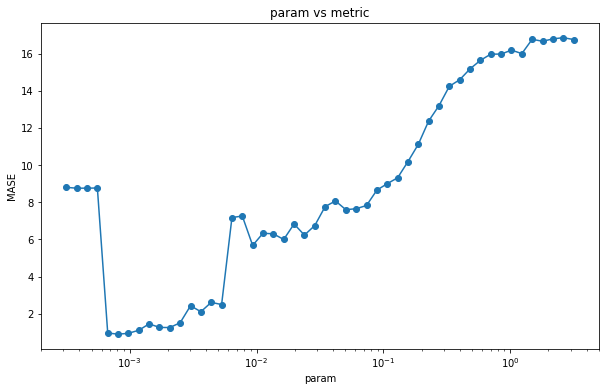

In [7]:
check_hyperparams(enc_train, enc_test)

11:23:09 - cmdstanpy - INFO - Chain [1] start processing
11:23:10 - cmdstanpy - INFO - Chain [1] done processing
11:23:10 - cmdstanpy - INFO - Chain [1] start processing
11:23:10 - cmdstanpy - INFO - Chain [1] done processing
11:23:10 - cmdstanpy - INFO - Chain [1] start processing
11:23:10 - cmdstanpy - INFO - Chain [1] done processing
11:23:10 - cmdstanpy - INFO - Chain [1] start processing
11:23:10 - cmdstanpy - INFO - Chain [1] done processing
11:23:11 - cmdstanpy - INFO - Chain [1] start processing
11:23:11 - cmdstanpy - INFO - Chain [1] done processing
11:23:11 - cmdstanpy - INFO - Chain [1] start processing
11:23:11 - cmdstanpy - INFO - Chain [1] done processing
11:23:11 - cmdstanpy - INFO - Chain [1] start processing
11:23:11 - cmdstanpy - INFO - Chain [1] done processing
11:23:11 - cmdstanpy - INFO - Chain [1] start processing
11:23:11 - cmdstanpy - INFO - Chain [1] done processing
11:23:12 - cmdstanpy - INFO - Chain [1] start processing
11:23:12 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 0.22229964825261944, MASE: 5.055439444701569
param: 0.01, MASE: 5.056569617210243
param: 0.16768329368110083, MASE: 5.056644991285578
param: 0.9102981779915218, MASE: 5.061410827591152
param: 11.513953993264469, MASE: 5.076033849761514


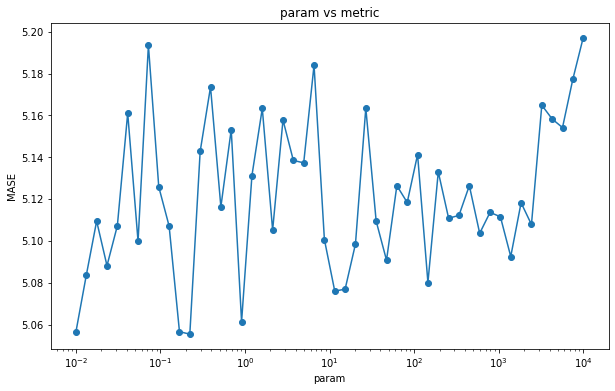

In [8]:
check_hyperparams(enc_train, enc_test, param='seasonality_prior_scale')

11:26:46 - cmdstanpy - INFO - Chain [1] start processing
11:26:46 - cmdstanpy - INFO - Chain [1] done processing
11:26:46 - cmdstanpy - INFO - Chain [1] start processing
11:26:46 - cmdstanpy - INFO - Chain [1] done processing
11:26:47 - cmdstanpy - INFO - Chain [1] start processing
11:26:47 - cmdstanpy - INFO - Chain [1] done processing
11:26:47 - cmdstanpy - INFO - Chain [1] start processing
11:26:47 - cmdstanpy - INFO - Chain [1] done processing
11:26:47 - cmdstanpy - INFO - Chain [1] start processing
11:26:47 - cmdstanpy - INFO - Chain [1] done processing
11:26:48 - cmdstanpy - INFO - Chain [1] start processing
11:26:48 - cmdstanpy - INFO - Chain [1] done processing
11:26:48 - cmdstanpy - INFO - Chain [1] start processing
11:26:48 - cmdstanpy - INFO - Chain [1] done processing
11:26:48 - cmdstanpy - INFO - Chain [1] start processing
11:26:48 - cmdstanpy - INFO - Chain [1] done processing
11:26:48 - cmdstanpy - INFO - Chain [1] start processing
11:26:48 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 12.067926406393289, MASE: 5.023644728064364
param: 13.257113655901088, MASE: 5.025958691630932
param: 23.29951810515372, MASE: 5.032872205436005
param: 15.998587196060582, MASE: 5.035344318611436
param: 65.51285568595509, MASE: 5.063834094941886


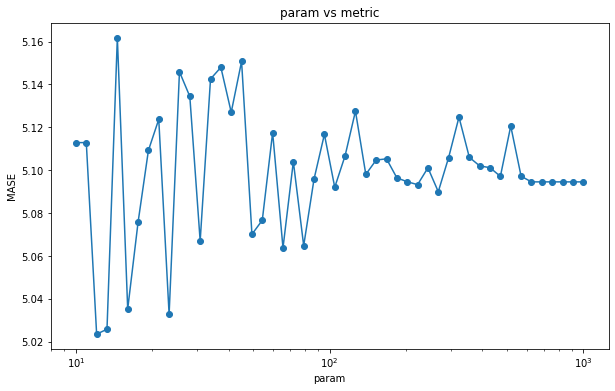

In [9]:
check_hyperparams(enc_train, enc_test, param = 'n_changepoints')

In [12]:
model, models, forecast_enc, fig1, fig2 = search_prophet(enc_train, enc_test, changepoints=[.00081, .0012, .00067, .00098, .0021], seasonalities=[.22, .01, .17, .91, 11.5], n_changepoints_vals=[12, 13, 23, 16, 66])

11:28:58 - cmdstanpy - INFO - Chain [1] start processing
11:28:58 - cmdstanpy - INFO - Chain [1] done processing
11:28:59 - cmdstanpy - INFO - Chain [1] start processing
11:28:59 - cmdstanpy - INFO - Chain [1] done processing
11:29:00 - cmdstanpy - INFO - Chain [1] start processing
11:29:00 - cmdstanpy - INFO - Chain [1] done processing
11:29:00 - cmdstanpy - INFO - Chain [1] start processing
11:29:00 - cmdstanpy - INFO - Chain [1] done processing
11:29:01 - cmdstanpy - INFO - Chain [1] start processing
11:29:01 - cmdstanpy - INFO - Chain [1] done processing
11:29:02 - cmdstanpy - INFO - Chain [1] start processing
11:29:02 - cmdstanpy - INFO - Chain [1] done processing
11:29:02 - cmdstanpy - INFO - Chain [1] start processing
11:29:02 - cmdstanpy - INFO - Chain [1] done processing
11:29:03 - cmdstanpy - INFO - Chain [1] start processing
11:29:03 - cmdstanpy - INFO - Chain [1] done processing
11:29:03 - cmdstanpy - INFO - Chain [1] start processing
11:29:03 - cmdstanpy - INFO - Chain [1]

11:27:46 - cmdstanpy - INFO - Chain [1] start processing
11:27:46 - cmdstanpy - INFO - Chain [1] done processing
11:27:46 - cmdstanpy - INFO - Chain [1] start processing
11:27:47 - cmdstanpy - INFO - Chain [1] done processing
11:27:47 - cmdstanpy - INFO - Chain [1] start processing
11:27:47 - cmdstanpy - INFO - Chain [1] done processing
11:27:48 - cmdstanpy - INFO - Chain [1] start processing
11:27:48 - cmdstanpy - INFO - Chain [1] done processing
11:27:49 - cmdstanpy - INFO - Chain [1] start processing
11:27:49 - cmdstanpy - INFO - Chain [1] done processing
11:27:49 - cmdstanpy - INFO - Chain [1] start processing
11:27:49 - cmdstanpy - INFO - Chain [1] done processing
11:27:50 - cmdstanpy - INFO - Chain [1] start processing
11:27:50 - cmdstanpy - INFO - Chain [1] done processing
11:27:51 - cmdstanpy - INFO - Chain [1] start processing
11:27:51 - cmdstanpy - INFO - Chain [1] done processing
11:27:52 - cmdstanpy - INFO - Chain [1] start processing
11:27:52 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.001
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

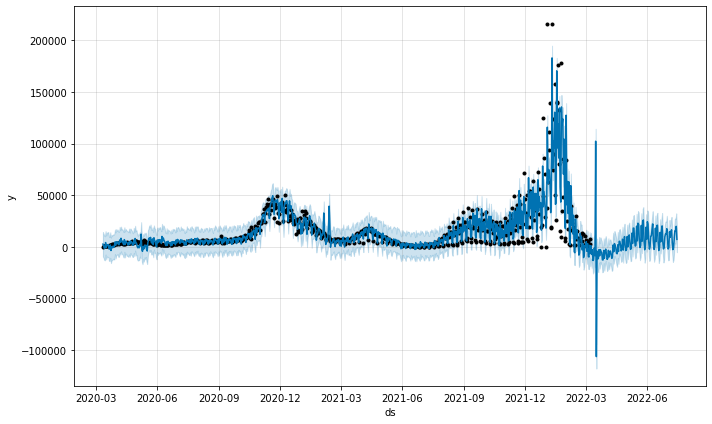

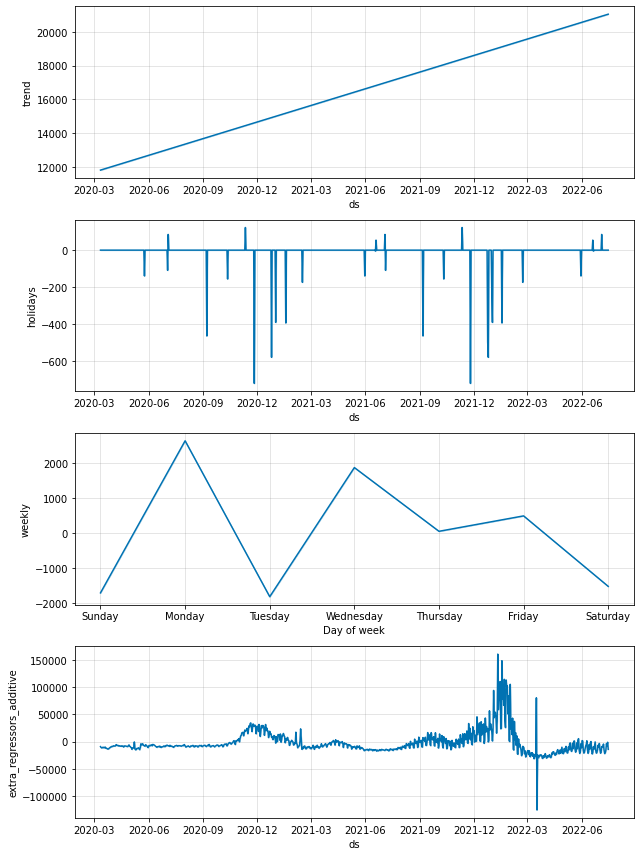

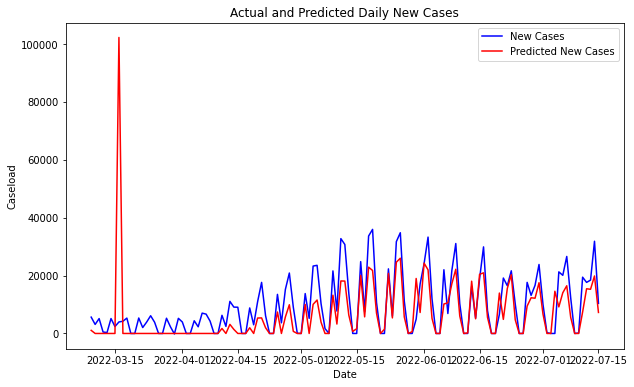

MAE: 5215.836564625996
RMSE: 10598.207942599996
MSE: 112322011.59458964
MASE: 0.5959945627350505


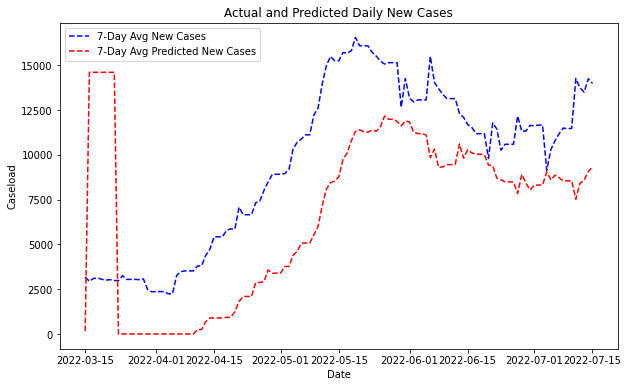

7-Day Avg MAE: 4194.111366007589
7-Day Avg RMSE: 4827.391447711775
7-Day Avg MSE: 23303708.18944079
7-Day Avg MASE: 10.403780090461462
7-Day Avg MAPE: 0.6789766547639787


In [11]:
model, models, forecast_enc, fig1, fig2 = search_prophet(enc_train, enc_test)

# ESC

19:41:10 - cmdstanpy - INFO - Chain [1] start processing
19:41:10 - cmdstanpy - INFO - Chain [1] done processing
19:41:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:41:10 - cmdstanpy - INFO - Chain [1] start processing
19:41:27 - cmdstanpy - INFO - Chain [1] done processing
19:41:28 - cmdstanpy - INFO - Chain [1] start processing
19:41:28 - cmdstanpy - INFO - Chain [1] done processing
19:41:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:41:28 - cmdstanpy - INFO - Chain [1] start processing
19:41:32 - cmdstanpy - INFO - Chain [1] done processing
19:41:32 - cmdstanpy - INFO - Chain [1] start processing
19:41:32 - cmdstanpy - INFO - Chain [1] done processing
19:41:33 - cmdstanpy - INFO - Chain [1] start processing
19:41:33 - cmdstanpy - INFO - Chain [1] done processing
19:41:33 -

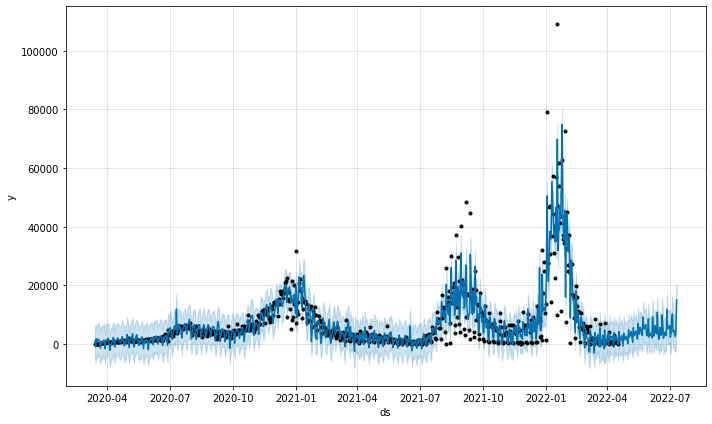

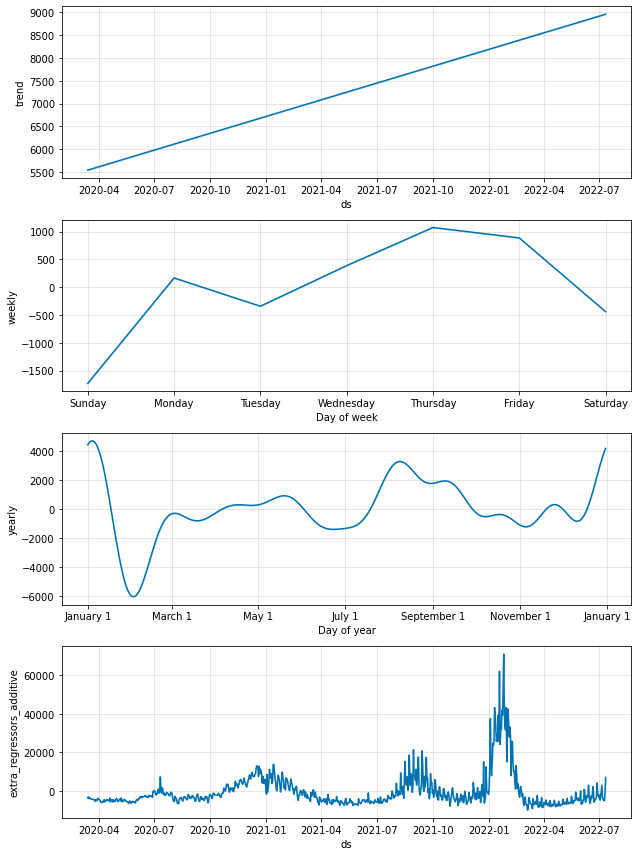

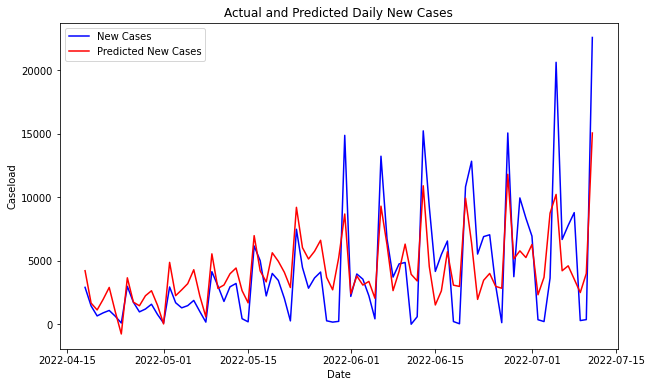

MAE: 2156.6611170249826
RMSE: 2813.857558318776
MSE: 7917794.358507702
MASE: 0.615032044589933


In [179]:
model, models, forecast_esc, fig1, fig2 = search_prophet(esc_train, esc_test)

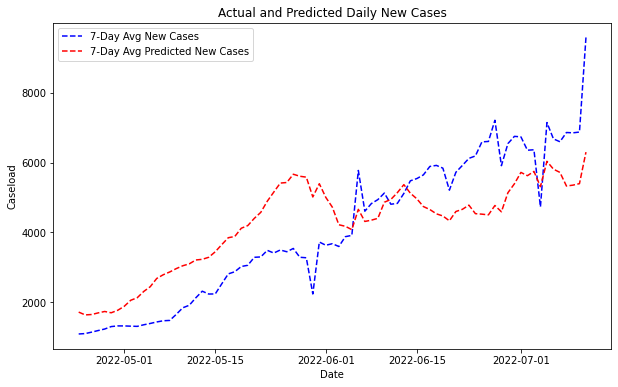

In [181]:
test = esc_test.copy()
test['7_day_avg'] = test['y'].rolling(window=7).mean()
forecast_esc['7_day_avg'] = forecast_esc['yhat'].rolling(window=7).mean()

plt.figure(figsize = (10,6))
# Plot the actual new cases and their rolling average
# plt.plot(test['ds'], test['y'], label='New Cases', color='blue')
plt.plot(test['ds'], test['7_day_avg'], label='7-Day Avg New Cases', color='blue', linestyle='--')

# Plot the predicted new cases and their rolling average
# plt.plot(forecast_mount['ds'], forecast_mount['yhat'], label='Predicted New Cases', color='red')
plt.plot(forecast_esc['ds'], forecast_esc['7_day_avg'], label='7-Day Avg Predicted New Cases', color='red', linestyle='--')

# Uncomment the following line if you want to include the prediction intervals
# plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Caseload')
plt.title('Actual and Predicted Daily New Cases')
plt.legend()
plt.show()

# MidATL

19:44:13 - cmdstanpy - INFO - Chain [1] start processing
19:44:13 - cmdstanpy - INFO - Chain [1] done processing
19:44:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:44:13 - cmdstanpy - INFO - Chain [1] start processing
19:44:19 - cmdstanpy - INFO - Chain [1] done processing
19:44:20 - cmdstanpy - INFO - Chain [1] start processing
19:44:20 - cmdstanpy - INFO - Chain [1] done processing
19:44:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:44:20 - cmdstanpy - INFO - Chain [1] start processing
19:44:25 - cmdstanpy - INFO - Chain [1] done processing
19:44:25 - cmdstanpy - INFO - Chain [1] start processing
19:44:26 - cmdstanpy - INFO - Chain [1] done processing
19:44:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

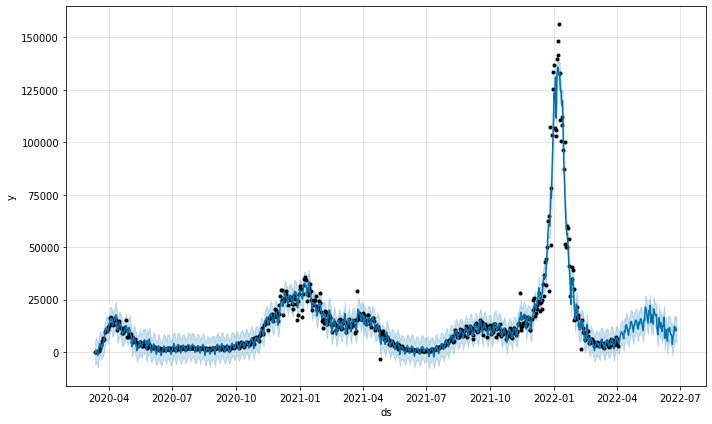

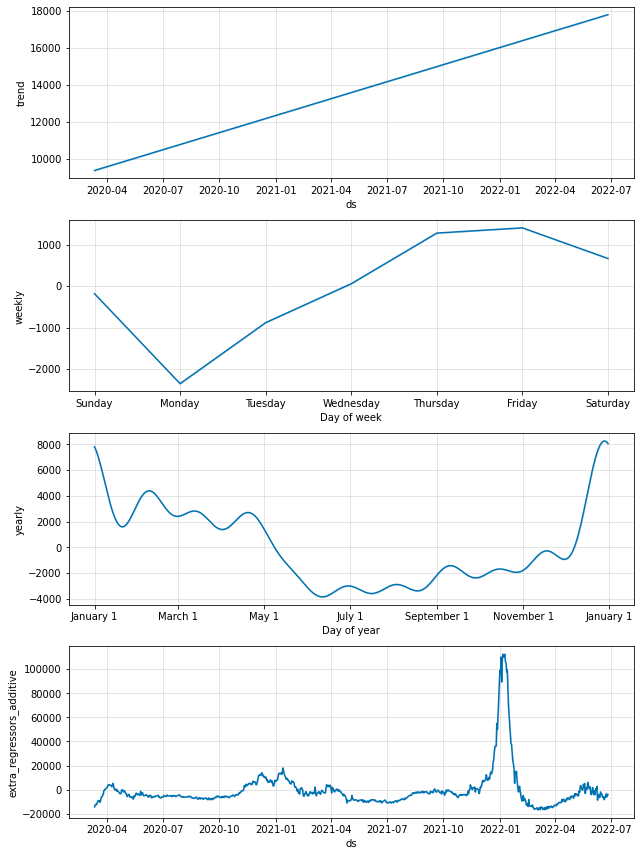

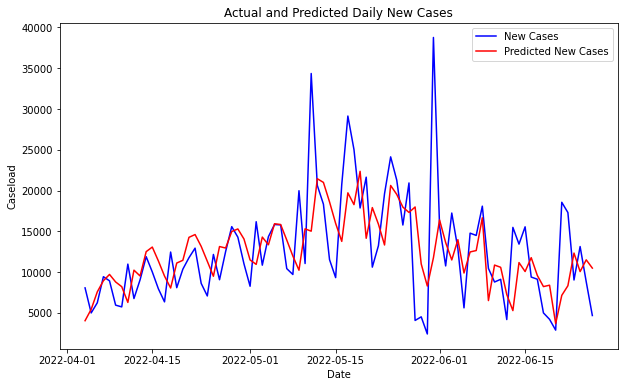

MAE: 4105.452176383699
RMSE: 5784.489680656039
MSE: 33460320.865616202
MASE: 0.7836670299754082


In [182]:
model_atl, models_atl, forecast_midatl, fig1, fig2 = search_prophet(midatl_train, midatl_test)

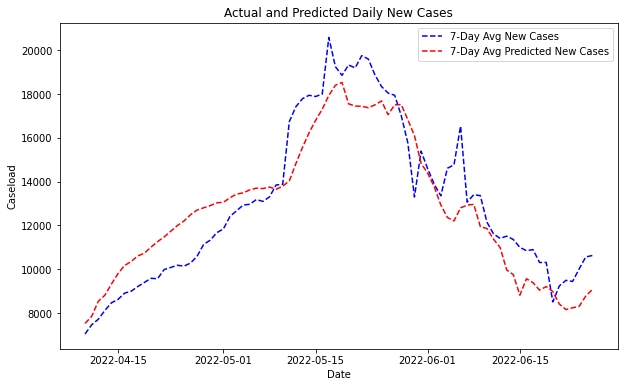

In [183]:
test = midatl_test.copy()
test['7_day_avg'] = test['y'].rolling(window=7).mean()
forecast_midatl['7_day_avg'] = forecast_midatl['yhat'].rolling(window=7).mean()

plt.figure(figsize = (10,6))
# Plot the actual new cases and their rolling average
# plt.plot(test['ds'], test['y'], label='New Cases', color='blue')
plt.plot(test['ds'], test['7_day_avg'], label='7-Day Avg New Cases', color='blue', linestyle='--')

# Plot the predicted new cases and their rolling average
# plt.plot(forecast_mount['ds'], forecast_mount['yhat'], label='Predicted New Cases', color='red')
plt.plot(forecast_midatl['ds'], forecast_midatl['7_day_avg'], label='7-Day Avg Predicted New Cases', color='red', linestyle='--')

# Uncomment the following line if you want to include the prediction intervals
# plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Caseload')
plt.title('Actual and Predicted Daily New Cases')
plt.legend()
plt.show()

# Mountain

19:34:02 - cmdstanpy - INFO - Chain [1] start processing
19:34:02 - cmdstanpy - INFO - Chain [1] done processing
19:34:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:34:02 - cmdstanpy - INFO - Chain [1] start processing
19:34:06 - cmdstanpy - INFO - Chain [1] done processing
19:34:07 - cmdstanpy - INFO - Chain [1] start processing
19:34:07 - cmdstanpy - INFO - Chain [1] done processing
19:34:07 - cmdstanpy - INFO - Chain [1] start processing
19:34:08 - cmdstanpy - INFO - Chain [1] done processing
19:34:08 - cmdstanpy - INFO - Chain [1] start processing
19:34:08 - cmdstanpy - INFO - Chain [1] done processing
19:34:09 - cmdstanpy - INFO - Chain [1] start processing
19:34:09 - cmdstanpy - INFO - Chain [1] done processing
19:34:09 - cmdstanpy - INFO - Chain [1] start processing
19:34:09 - cmdstanpy - INFO - Chain [1] done processing
19:34:10 - cmdstanpy - INFO - Chain [1] start process

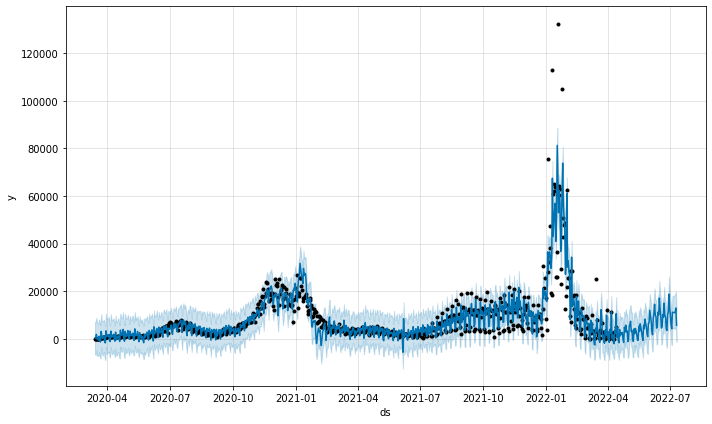

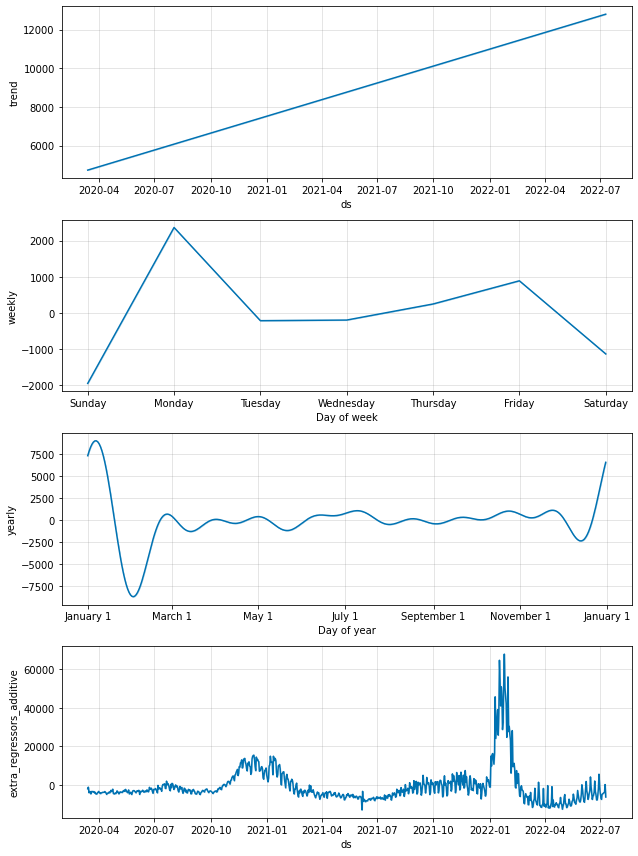

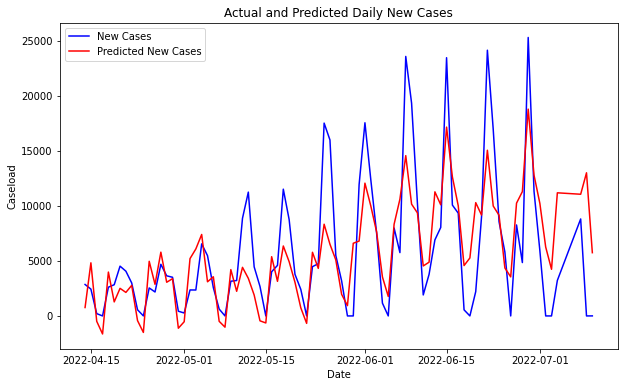

MAE: 3083.9399944050388
RMSE: 4161.510378729469
MSE: 17318168.63227309
MASE: 0.7036388069557534


In [169]:
model_mount, models_mount, forecast_mount, fig1, fig2 = search_prophet(mount_train, mount_test)

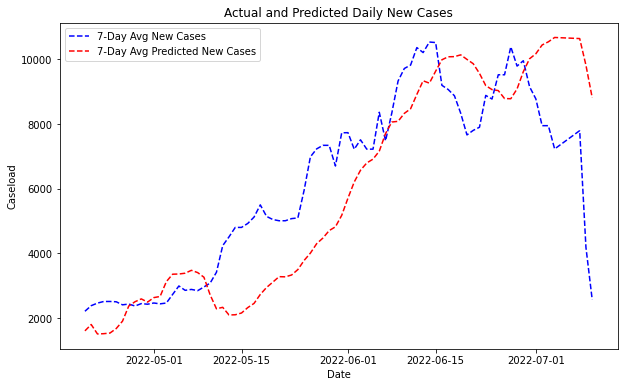

In [174]:
test = mount_test.copy()
test['7_day_avg'] = test['y'].rolling(window=7).mean()
forecast_mount['7_day_avg'] = forecast_mount['yhat'].rolling(window=7).mean()

plt.figure(figsize = (10,6))
# Plot the actual new cases and their rolling average
# plt.plot(test['ds'], test['y'], label='New Cases', color='blue')
plt.plot(test['ds'], test['7_day_avg'], label='7-Day Avg New Cases', color='blue', linestyle='--')

# Plot the predicted new cases and their rolling average
# plt.plot(forecast_mount['ds'], forecast_mount['yhat'], label='Predicted New Cases', color='red')
plt.plot(forecast_mount['ds'], forecast_mount['7_day_avg'], label='7-Day Avg Predicted New Cases', color='red', linestyle='--')

# Uncomment the following line if you want to include the prediction intervals
# plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Caseload')
plt.title('Actual and Predicted Daily New Cases')
plt.legend()
plt.show()